## Catchment Hydrology, MSc course
### Lecture 1: Characteristics of hydrologic timeseries
#### Wouter R. Berghuijs (w.r.berghuijs@vu.nl)

In this notebook you will gain some experience in working with hydrological timeseries. You will use data from a small pre-Alpine Erlenbach catchment. The purpose is that you familiarize yourself with hydrological timeseries, and can derive and interpret several characteristics from such timeseries such as:
- Runoff ratio
- Flow duration curve
- Probability density function
- Flow quantiles
- Annual maxima, minima, and averages
- Coefficient of variation
- Skewness
- Kurtosis
- Relative rate of different hydrological fluxes
- Relative variability of hydrological fluxes
- Snow water equivalent
- Hydrological (or water) year
- Unit conversion

### Site description [From Freyberg et al., 2018, HESS]
The Erlenbach research catchment is located in the northern Swiss pre-Alps roughly 40 km south of Zurich. The 0.7 km$^2$ catchment spans an elevation range from 1100 to 1655 masl. The bedrock geology consists of alternating layers of conglomerates, clay and marl shales, limestone and calcareous sandstones, with lithological boundaries nearly perpendicular to the main valley axis. Due to the layering and the diversity of the bedrock material, the landscape in the upper half of the catchment is divided into a sequence of steep hillslopes and plateaus. On the plateaus, groundwater tables are shallow, and mollic Gleysols with a carbonaterich topsoil predominate; the hillslopes are mostly covered with macropore-rich Umbric Gleysols. Overall, the soils reach maximum depths of around 2.5m in depressions on the plateaus, while soils are shallower (0.5– 1 m) on steeper slopes. Due to the high clay content of the flysch material, the bedrock and soils are generally characterized by low permeabilities and are prone to waterlogging. Annual precipitation at Erlenbach averages roughly 1850 mm/yr (over the period 2000–2015), with monthly maxima and minima in June and October, respectively. In years with cold winters, up to 40% of annual precipitation falls as snow, and in summer, frequent thunderstorms generate pronounced peaks in streamflow. Below you can find some impressions of the catchment 

(maps from Freyberg et al., 2018, https://doi.org/10.5194/hess-22-5847-2018, Photos from: https://www.wsl.ch/en/about-wsl/instrumented-field-sites-and-laboratories/experimented-field-sites-for-natural-hazards/torrent-investigation-in-the-alptal/image-gallery-1.html)

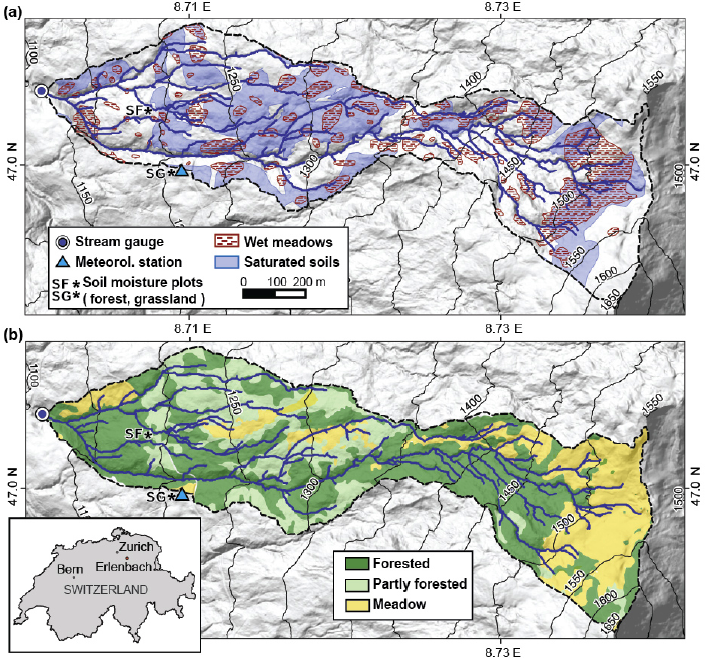



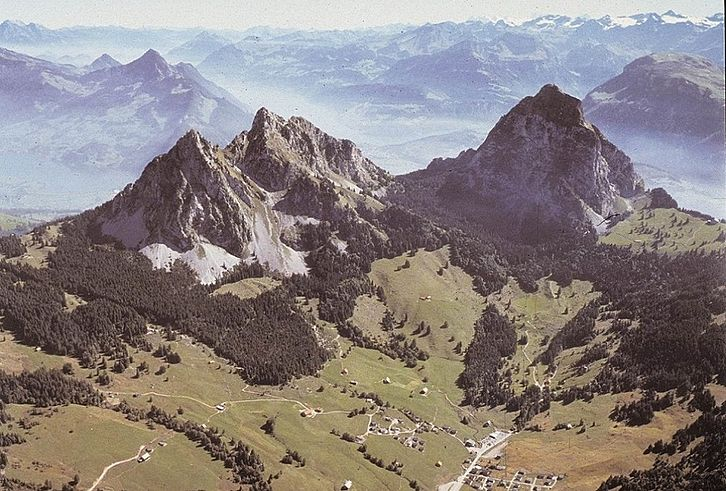


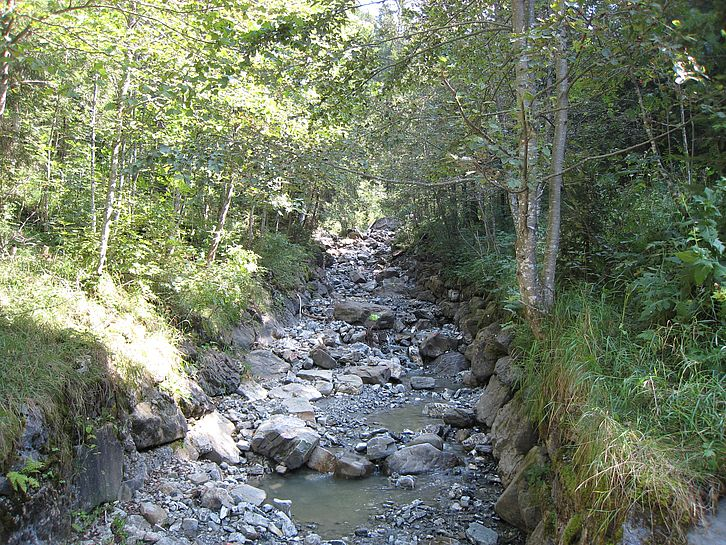

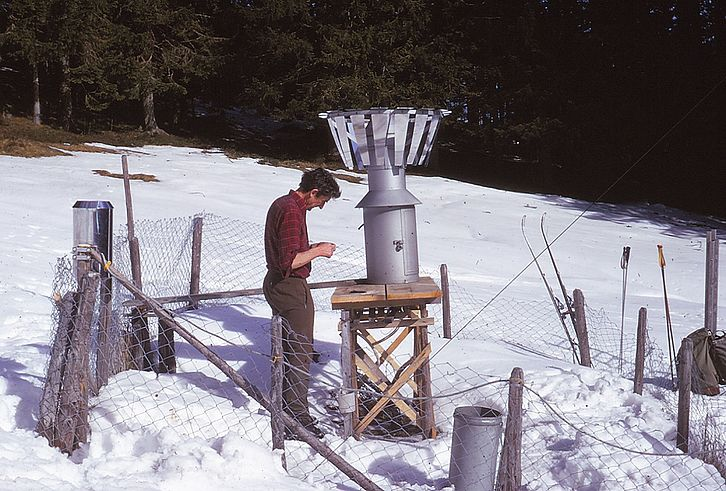

## Hydrological timeseries
The Swiss Federal Institute for Forest, Snow and Landscape Research WSL has recorded  streamflow in the Alpthal since 1968. Below we will load the data from the Erlenbach research catchment into this Python script to study these data

In [1]:
## We first import the Python packages

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [2]:
## We now load the data (which is stored in an .xlxs-file, into this notebook) using Pandas
## Pandas is a fast, flexible and easy to use open source data analysis. 
## If you are curious: You can open the excel file by manually (in excel) to see what this datafile looks like

# Specify where the data is stored
file_path =  'ErlenbachQ.xls'

# Create dataframe with streamflow data from Alpthal catchment 
# A dataframe is a 2D data structure, like a table with rows and columns.
dfQ = pd.read_excel(file_path, skiprows=7)

# We here give each column within the dataframe a name that reflect what data they store
column_name_mapping = {
    'Unnamed: 0': 'Date',                # The date (yyyy-mm-dd)
    '(l/sec)': 'StreamflowUpStream',     # Streamflow values upstream (liters per second)
    '(l/sec).1': 'StreamflowDownStream', # Streamflow values at catchment outlet (liters per second)
    '(oC)': 'WaterTemp',                 # Water temperature (Celsius)
    '(microS/cm at 20 oC)': 'Conductivity' # Water temperature (microS/cm)
}
dfQ.rename(columns=column_name_mapping, inplace=True)

# When no measurements are available the data were listed as -999, we change these to NaN-values. 
dfQ[dfQ == -999] = np.nan

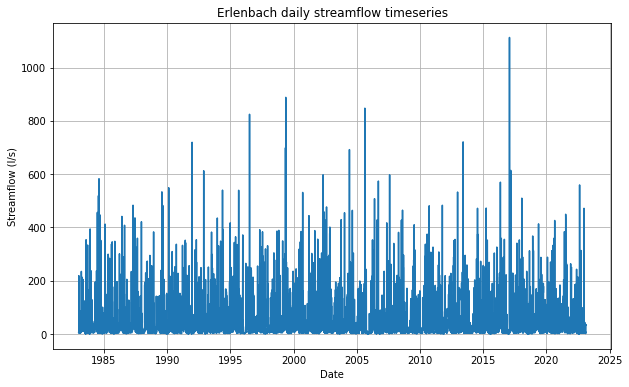

In [3]:
# We can check if the data are indeed correctly plotting the streamflow timeseries 

plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
plt.plot(dfQ['Date'], dfQ['StreamflowDownStream'])
plt.xlabel('Date')
plt.ylabel('Streamflow (l/s)')
plt.title('Erlenbach daily streamflow timeseries')
plt.grid(True)
plt.show()

# Note that the figure below should show a timeseries.
# However, these data are hard to interpret as ~40 years of data 
# (thus close to 15000 datapoints) are compressed into a small graph. 
# We will fix this later. 

In [4]:
# First we will also load the meteorological timeseries from an xlsx-file.
# We use a similar procedure as before 

# Specify path and create dataframe
file_path_1 ='meteorological-data_alptal_1968-2022_envidat_updated.xls'
dfP = pd.read_excel(file_path_1,  skiprows=17)

# Rename the dataframe columns. We will not use all variables (at this stage)
new_column_names = ['Date', 'AirTemp(Erlenhohe)', 'RelativeHumidity(Erlenhohe)', 'Windspeed(Erlenhohe)',  'Precip(Erlenhohe)',  'GlobalRadiation(Erlenhohe)',  'DewpointTemp(Erlenhohe)',  'Precipitation(Vogelbach)', 'Precipitation(Lumpenbach)', 'SnowDepth(Erlenhohe)', 'ModeledSnowDepth(Erlenhohe)',   'SWE1(Erlenhohe)', 'SWE2(Erlenhohe)',   'Temperature(Einsiedeln)','Precip(Einsiedeln)']  # Add all the new column names in the order you want
if len(new_column_names) == len(dfP.columns):
    dfP.set_axis(new_column_names, axis=1, inplace=True) # , 

/var/folders/m6/29dmlndn6fq4qjsjj9238fy00000gn/T/ipykernel_30519/3143833897.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dfP.set_axis(new_column_names, axis=1, inplace=True) # ,


In [5]:
# We now also ensure all data is merged into a single dataframe we will call "merged_df" 

# We first convert the 'data' column to pandas datetime type
# and extract only the date part
dfQ['Date'] = pd.to_datetime(dfQ['Date']).dt.date
dfP['Date'] = pd.to_datetime(dfP['Date']).dt.date

# Find overlapping dates of the two overlapping dates based on the date part of both dataframes
overlapping_dates = pd.merge(dfQ[['Date']], dfP[['Date']], how='inner', on='Date')['Date']

# Now merge the DataFrames to have consistent dates and save all data in a new dataframe called "merged_df"
merged_df = pd.merge(dfQ, dfP, how='inner', on='Date')

(11961.0, 14152.0)

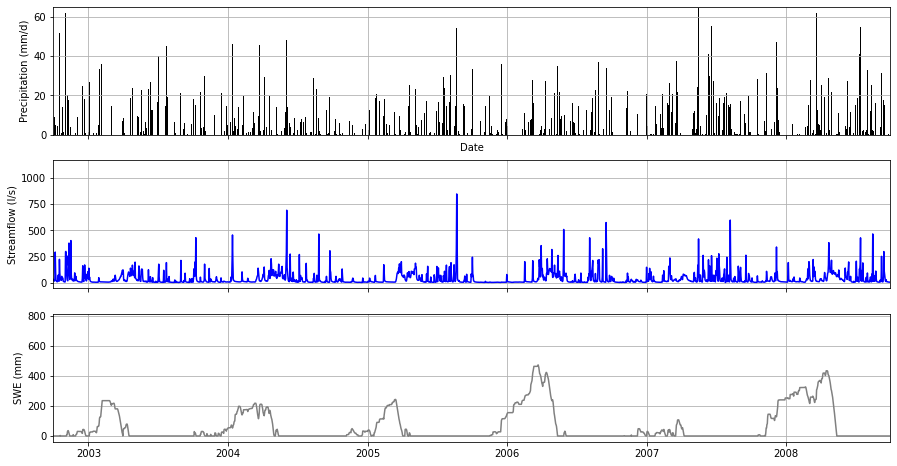

In [6]:
# We create a figure with three subplots and zoom into the period 2000-2009

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

# Plot precipitation timeseries (mm/d)
ax1.bar(merged_df['Date'], merged_df['Precip(Erlenhohe)'], color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (mm/d)')
ax1.grid(True)

# Plot streamflow timeseries (liters per second)
ax2.plot(merged_df['Date'], merged_df['StreamflowDownStream'], color='blue')
ax2.set_ylabel('Streamflow (l/s)')
ax2.set_yscale('linear')
ax2.grid(True)

# Plot snow water equivalent (mm)
ax3.plot(merged_df['Date'], merged_df['SWE1(Erlenhohe)'], color='grey')
ax3.set_ylabel('SWE (mm)')
ax3.grid(True)

# Set the x-axis limits for the date range 
date_range = pd.date_range(start='2002-10-01', end='2008-09-30')
ax1.set_xlim(date_range[0], date_range[-1])
ax1.set_ylim(0, 65)
ax2.set_xlim(date_range[0], date_range[-1])
ax3.set_xlim(date_range[0], date_range[-1])

### Questions

The graph shows 3 components of the catchment water balance. *Precipitation* expresses the daily incoming precipitation (in mm/d) based on one gauge. *Streamflow* expresses the daily flow rate (in liters per second). SWE expresses the **snow water equivalent** which expresses the equivalent amount of liquid water stored in the snow pack (in mm). (Use Dingman 5.2.1.+5.2.2 for Q1-Q2)

**Q1.** Why can it be useful to express the amount of snow storage in the catchment as a SWE? (rather than the actual physical depth of the snowpack)
**Q2.** If SWE would be 200mm, how deep would the snowpack roughly be? (and does it matter if its a fresh or an older snowpack?)

To ensure that we express different water balance components using consistent units, we convert streamflow into mm/d. In addition we calculate streamflow's mean value (again in mm/d)

In [7]:
merged_df['Streamflow_mmperday'] = merged_df['StreamflowDownStream']*86400/(0.7*10**6)
print('the mean streamflow rate is (in mm/d)',merged_df['Streamflow_mmperday'].mean())
print('the mean precipitation rate is (in mm/d)',merged_df['Precip(Erlenhohe)'].mean())

the mean streamflow rate is (in mm/d) 4.7579719741938495
the mean precipitation rate is (in mm/d) 6.267987232234965


**Q3.** In the Python code above, we multiplied the original streamflow data (which was in l/s) by 86400 and divided by $0.7 \cdot 10^6$. Why does this yield streamflow values in mm/d? 

**Q4.** One could calculate the average flow rate, and the average precipitation rate (see above). Based on this, what would you estimate that mean evaporation rate is of the Erlenbach?

**Q5.** The *runoff ratio* expresses mean streamflow rate divided by the mean precipitation rate. What is the measured *runoff ratio* of the catchment, and how does this compare to the mean global runoff ratio (which you can derive from the slide of lecture 1 on global water fluxes, or Table 2.6 of Dingman)? 

To get some idea about the degree of variability of streamflow, we will present the streamflow timeseries also on a logarithmic scale (see figure below)


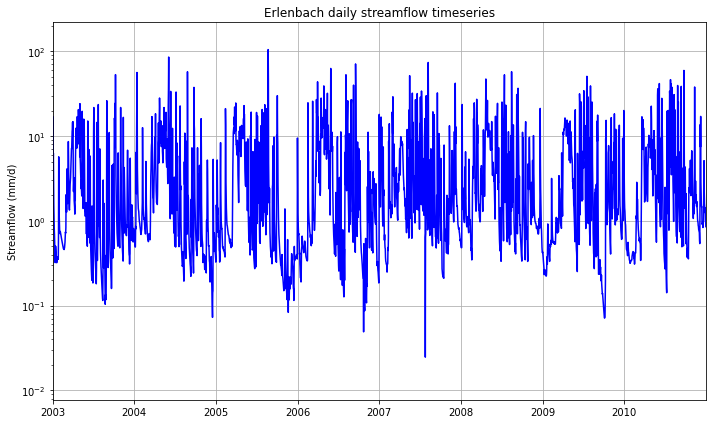

In [8]:
# Create a new figure and a single subplot for streamflow timeseries

# Plot streamflow on a logarithmic y-scale
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(merged_df['Date'], merged_df['StreamflowDownStream']*86400/(0.7*10**6), color='blue')
ax2.set_ylabel('Streamflow (mm/d)')
ax2.set_yscale('log')
ax2.set_title('Erlenbach daily streamflow timeseries')
ax2.grid(True)

# Set the x-axis limits for the date range from 2000 to 2010
date_range = pd.date_range(start='2003-01-01', end='2010-12-31')
ax2.set_xlim(date_range[0], date_range[-1])

# Display the plot
plt.tight_layout()
plt.show()

**Q6** This timeseries tells us quickly how much high flow conditions (the peaks) tend to differ from the low flow conditions in the catchment (the lower values on the graph). How many times larger are the high flows compared to low flows (roughly)? 

We also calculate some statistics (*Variance, Standard deviation, Coefficient of variation, Skewness, Kurtosis*, see Dingman C3.5) that more formally inform us about the variabillity of streamflow in the Erlenbach.

In [9]:
# Drop rows with NaN values in 'StreamflowDownStream' column
merged_df = merged_df.dropna(subset=['StreamflowDownStream'])

# Define variable of which we calculate statistics
X = merged_df['StreamflowDownStream']*86400/(0.7*10**6)

# Calculate variance
variance = np.var(X)

# Calculate coefficient of variation
mean_X = np.mean(X)
std_dev_X = np.std(X)
coeff_of_variation = (std_dev_X / mean_X) * 100

# Calculate skewness
skewness = skew(X)

# Calculate kurtosis
kurt = kurtosis(X)

# Print results
print("Variance:", variance)
print("Standard deviation:", std_dev_X)
print("Coefficient of Variation:", coeff_of_variation)
print("Skewness:", skewness)
print("Kurtosis:", kurt)

Variance: 62.839796068663496
Standard deviation: 7.927155610221329
Coefficient of Variation: 166.60786682259598
Skewness: 4.040366266391857
Kurtosis: 26.76316048149993


**Q7** What do the *Variance* and *standard deviation* express? And how are they related to another?

**Q8** What is the difference between the *coefficient of variation* and the *standard deviation*? Which of the two is an absolute measure, and which of them a relative measure? What are they units, and why are their units different?

**Q9** The *Skewness* is a measure of the symmetry a distribution, whereas the *Kurtosis* provides information about the shape of a dataset's distribution and indicates the extent to which its data points differ from those of a normal distribution. Based on the provided Skewness and Kurtosis, would you  consider streamflow values to be roughly normally distributed?

To get further understanding of how often particular flow rates are exceeded, we can make a *flow duration curve* (see Dingman 1.9.2.2). The flow-duration curve is a cumulative frequency curve that shows the percent of time specified discharges were equaled or exceeded during a given period. It combines in one curve the flow characteristics of a stream throughout the range of discharge, without regard to the sequence of occurrence. Let's make a flow duration curve for the Erlenbach.

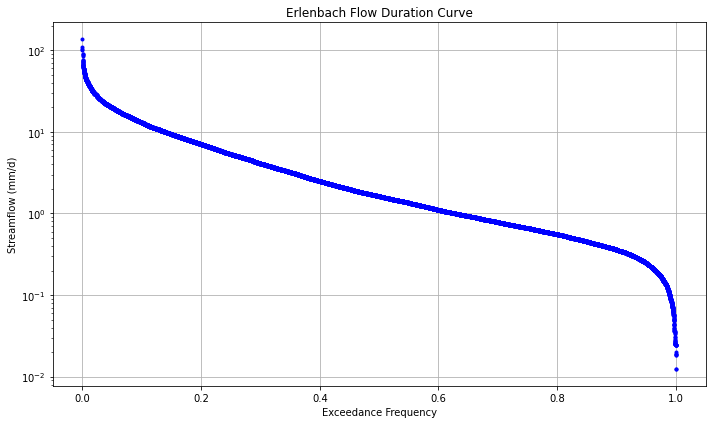

In [10]:
# Sort the 'StreamflowDownStream' values in descending order and assign ranks
merged_df['Rank'] = merged_df['StreamflowDownStream'].rank(ascending=False)

# Calculate the exceedance frequency as a fraction
total_points = len(merged_df)
merged_df['Exceedance'] = merged_df['Rank'] / total_points

# Plot streamflow on a logarithmic y-scale
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(merged_df['Exceedance'], merged_df['StreamflowDownStream']*86400/(0.7*10**6), '.',color='blue')
ax2.set_xlabel('Exceedance Frequency')
ax2.set_ylabel('Streamflow (mm/d)')
ax2.set_yscale('log')
ax2.set_title('Erlenbach Flow Duration Curve')
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

**Q10.** What is the *median flow* ($Q_{0.5}$) of this catchment? And why is this value lower than the mean flow rate we calculated before?

**Q11.** What percentage of time are flow rates exceeding 1 mm/d?

**Q12.** The flow duration curve is a *cumulative distribution* (see also Dingman C.3.2)). How would you derive a *probablity density function* from this graph?   

**Q13.** Would you consider the flow rate in the Erlenbach catchment constant or highly variable in time? For example, in comparison with what you would expect of the Rhine river entering NL at Lobith?

We wil now calculate *annual statistics* of the flow time timeseries (see below). These annual annual characteristics are calculated over the period Oct 1st - Sep 30th. This period is also called a *water year* or a *hydrological year*. 

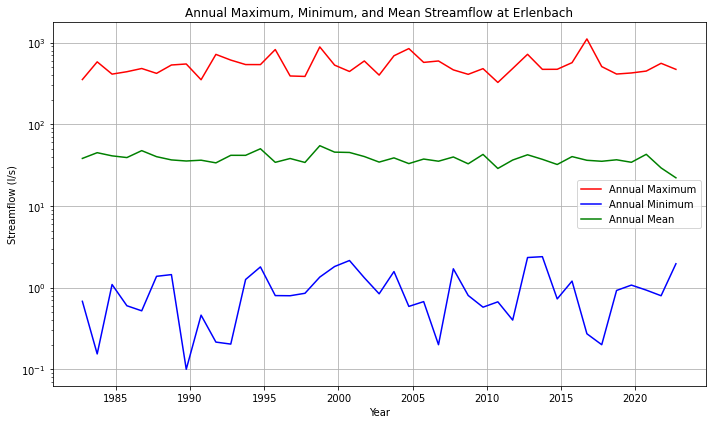

In [11]:
# Convert the 'Date' column to pandas datetime type if it's not already
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Set the 'Date' column as the index
merged_df.set_index('Date', inplace=True)

# Resample the data to one-year periods (from October 1st to August 30th)
resampled_df = merged_df.resample('AS-OCT').agg({
    'StreamflowDownStream': ['max', 'min', 'mean']
})

# Drop rows with NaN values in the resampled DataFrame
resampled_df = resampled_df.dropna()

# Plot the annual maximum, minimum, and mean flow values on a logarithmic y-axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(resampled_df.index, resampled_df['StreamflowDownStream']['max'], label='Annual Maximum', color='red')
ax.plot(resampled_df.index, resampled_df['StreamflowDownStream']['min'], label='Annual Minimum', color='blue')
ax.plot(resampled_df.index, resampled_df['StreamflowDownStream']['mean'], label='Annual Mean', color='green')

ax.set_xlabel('Year')
ax.set_ylabel('Streamflow (l/s)')
ax.set_title('Annual Maximum, Minimum, and Mean Streamflow at Erlenbach')
ax.legend()
ax.grid(True)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

plt.tight_layout()
plt.show()

**Q14.** Why do hydrologists tend to use water years, rather than regular calendar years? (Dingman 1.8.2.4)

**Q15.** Which flow conditions are most variable between years (means, max, or min) and why do you expect this is the case? (Dingman 1.9.2)